# Mandelbrot With Blosc2 DSL vs Blosc2+Numba

This notebook compares two Blosc2-backed execution paths for Mandelbrot side-by-side:
- `@blosc2.dsl_kernel` through `blosc2.lazyudf` (`blosc2+DSL`)
- a Numba-compiled `lazyudf` kernel (`blosc2+numba`), following the pattern in `compute_udf_numba.py`

The previous native Numba implementation is moved earlier as a baseline and is still plotted for visual comparison.


In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

import blosc2

In [2]:
# Problem size and Mandelbrot domain
WIDTH = 1200
HEIGHT = 800
MAX_ITER = 200
X_MIN, X_MAX = -2.0, 0.6
Y_MIN, Y_MAX = -1.1, 1.1
DTYPE = np.float32

x = np.linspace(X_MIN, X_MAX, WIDTH, dtype=DTYPE)
y = np.linspace(Y_MIN, Y_MAX, HEIGHT, dtype=DTYPE)
cr_np, ci_np = np.meshgrid(x, y)

# Keep compression overhead low for the timing comparison
cparams_fast = blosc2.CParams(codec=blosc2.Codec.LZ4, clevel=1)
cr_b2 = blosc2.asarray(cr_np, cparams=cparams_fast)
ci_b2 = blosc2.asarray(ci_np, cparams=cparams_fast)

print(f"grid: {cr_np.shape}, dtype: {cr_np.dtype}")

grid: (800, 1200), dtype: float32


In [3]:
@blosc2.dsl_kernel
def mandelbrot_dsl(cr, ci, max_iter):
    # max_iter is passed per-call through lazyudf inputs
    zr = 0.0
    zi = 0.0
    escape_iter = float(max_iter)
    for it in range(max_iter):
        zr2 = zr * zr
        zi2 = zi * zi
        mag2 = zr2 + zi2

        active = escape_iter == float(max_iter)
        just_escaped = (mag2 > 4.0) & active
        escape_iter = np.where(just_escaped, it, escape_iter)

        active = escape_iter == float(max_iter)
        if np.all(active == 0):
            break

        zr_new = zr2 - zi2 + cr
        zi_new = 2.0 * zr * zi + ci
        zr = np.where(active, zr_new, zr)
        zi = np.where(active, zi_new, zi)

    return escape_iter


if mandelbrot_dsl.dsl_source is None:
    raise RuntimeError("DSL extraction failed. Re-run this cell in a file-backed notebook session.")

print(mandelbrot_dsl.dsl_source)

def mandelbrot_dsl(cr, ci, max_iter):
    zr = 0.0
    zi = 0.0
    escape_iter = float(max_iter)
    for it in range(max_iter):
        zr2 = (zr * zr)
        zi2 = (zi * zi)
        mag2 = (zr2 + zi2)
        active = (escape_iter == float(max_iter))
        just_escaped = ((mag2 > 4.0) & active)
        escape_iter = where(just_escaped, it, escape_iter)
        active = (escape_iter == float(max_iter))
        if all((active == 0)):
            break
        zr_new = ((zr2 - zi2) + cr)
        zi_new = (((2.0 * zr) * zi) + ci)
        zr = where(active, zr_new, zr)
        zi = where(active, zi_new, zi)
    return escape_iter


In [4]:
@njit(parallel=True, fastmath=False)
def mandelbrot_numba_native(cr, ci, max_iter):
    h, w = cr.shape
    out = np.empty((h, w), dtype=np.float32)
    for iy in prange(h):
        for ix in range(w):
            zr = np.float32(0.0)
            zi = np.float32(0.0)
            escape_iter = np.float32(max_iter)
            c_re = cr[iy, ix]
            c_im = ci[iy, ix]
            for it in range(max_iter):
                zr2 = zr * zr
                zi2 = zi * zi
                if zr2 + zi2 > np.float32(4.0):
                    escape_iter = np.float32(it)
                    break
                zr_new = zr2 - zi2 + c_re
                zi_new = np.float32(2.0) * zr * zi + c_im
                zr = zr_new
                zi = zi_new
            out[iy, ix] = escape_iter
    return out


@njit(parallel=True, fastmath=False)
def mandelbrot_numba_lazyudf(inputs_tuple, output, offset):
    cr = inputs_tuple[0]
    ci = inputs_tuple[1]
    max_iter = np.int32(MAX_ITER)
    h, w = output.shape
    for iy in prange(h):
        for ix in range(w):
            zr = np.float32(0.0)
            zi = np.float32(0.0)
            escape_iter = np.float32(max_iter)
            c_re = cr[iy, ix]
            c_im = ci[iy, ix]
            for it in range(max_iter):
                zr2 = zr * zr
                zi2 = zi * zi
                if zr2 + zi2 > np.float32(4.0):
                    escape_iter = np.float32(it)
                    break
                zr_new = zr2 - zi2 + c_re
                zi_new = np.float32(2.0) * zr * zi + c_im
                zr = zr_new
                zi = zi_new
            output[iy, ix] = escape_iter

In [5]:
def best_time(func, repeats=3, warmup=1):
    for _ in range(warmup):
        func()
    best = float("inf")
    best_out = None
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = func()
        dt = time.perf_counter() - t0
        if dt < best:
            best = dt
            best_out = out
    return best, best_out


def run_numba_native():
    return mandelbrot_numba_native(cr_np, ci_np, MAX_ITER)


def run_blosc2_numba():
    lazy = blosc2.lazyudf(mandelbrot_numba_lazyudf, (cr_b2, ci_b2), dtype=np.float32, cparams=cparams_fast)
    return lazy.compute()[...]


def run_dsl():
    lazy = blosc2.lazyudf(mandelbrot_dsl, (cr_b2, ci_b2, MAX_ITER), dtype=np.float32, cparams=cparams_fast)
    return lazy.compute()[...]


# Measure first iteration (includes one-time overhead, especially Numba JIT compile)
t0 = time.perf_counter()
_ = run_numba_native()
t_numba_native_first = time.perf_counter() - t0

t0 = time.perf_counter()
_ = run_blosc2_numba()
t_b2_numba_first = time.perf_counter() - t0

t0 = time.perf_counter()
_ = run_dsl()
t_dsl_first = time.perf_counter() - t0


t_numba_native, img_numba_native = best_time(run_numba_native, repeats=5, warmup=1)
t_b2_numba, img_b2_numba = best_time(run_blosc2_numba, repeats=3, warmup=1)
t_dsl, img_dsl = best_time(run_dsl, repeats=3, warmup=1)

max_abs_diff_dsl_vs_b2_numba = float(np.max(np.abs(img_dsl - img_b2_numba)))
max_abs_diff_native_vs_b2_numba = float(np.max(np.abs(img_numba_native - img_b2_numba)))
max_abs_diff_native_vs_dsl = float(np.max(np.abs(img_numba_native - img_dsl)))

print("First iteration timings (one-time overhead included):")
print(f"Native numba first run (baseline): {t_numba_native_first:.6f} s")
print(f"Blosc2+numba first run:            {t_b2_numba_first:.6f} s")
print(f"Blosc2+DSL first run:              {t_dsl_first:.6f} s")

print("\nBest-time stats:")
print(f"Native numba time (best): {t_numba_native:.6f} s")
print(f"Blosc2+numba time (best): {t_b2_numba:.6f} s")
print(f"Blosc2+DSL time (best):   {t_dsl:.6f} s")
print(f"Blosc2+numba / native:    {t_b2_numba / t_numba_native:.2f}x")
print(f"Blosc2+DSL / native:      {t_dsl / t_numba_native:.2f}x")
print(f"Blosc2+DSL / Blosc2+numba: {t_dsl / t_b2_numba:.2f}x")
print(f"max |dsl-b2_numba|:       {max_abs_diff_dsl_vs_b2_numba:.6f}")
print(f"max |native-b2_numba|:    {max_abs_diff_native_vs_b2_numba:.6f}")
print(f"max |native-dsl|:         {max_abs_diff_native_vs_dsl:.6f}")

First iteration timings (one-time overhead included):
Native numba first run (baseline): 0.365377 s
Blosc2+numba first run:            0.194033 s
Blosc2+DSL first run:              0.336405 s

Best-time stats:
Native numba time (best): 0.024439 s
Blosc2+numba time (best): 0.026728 s
Blosc2+DSL time (best):   0.331109 s
Blosc2+numba / native:    1.09x
Blosc2+DSL / native:      13.55x
Blosc2+DSL / Blosc2+numba: 12.39x
max |dsl-b2_numba|:       0.000000
max |native-b2_numba|:    0.000000
max |native-dsl|:         0.000000


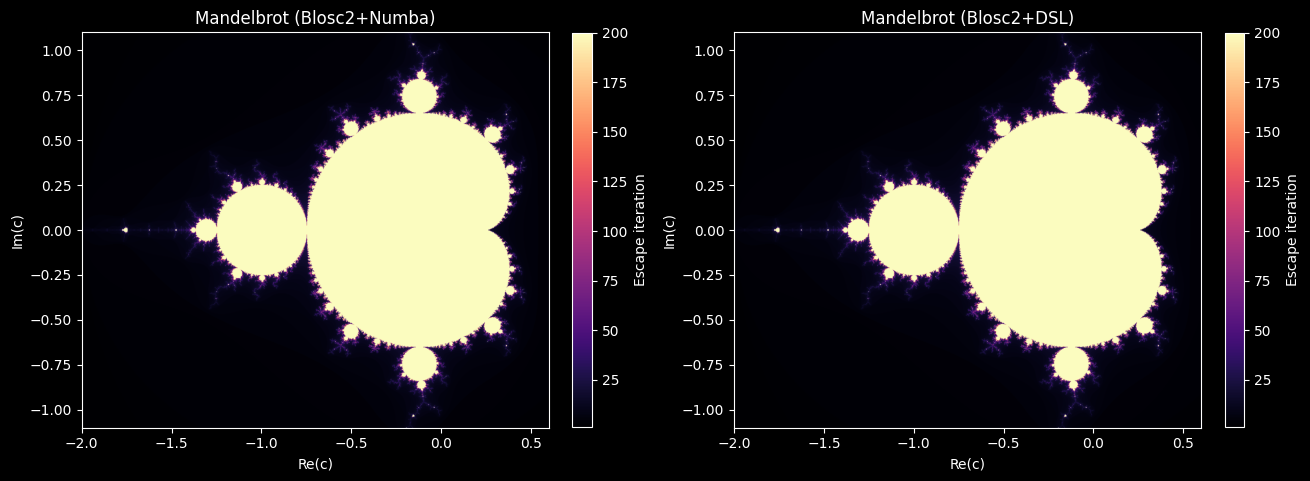

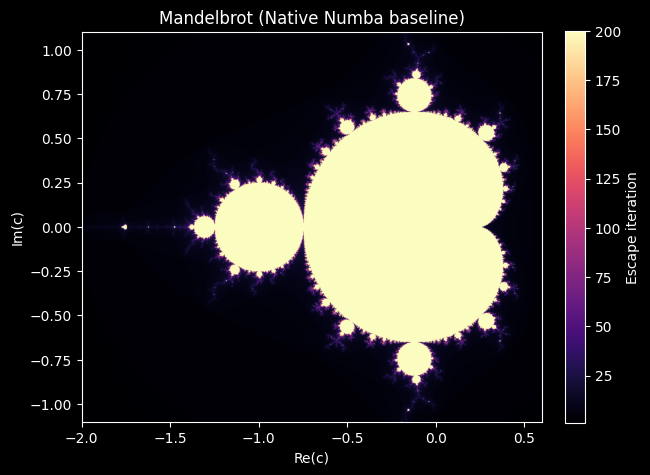

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

im0 = ax[0].imshow(
    img_b2_numba,
    cmap="magma",
    extent=(X_MIN, X_MAX, Y_MIN, Y_MAX),
    origin="lower",
)
ax[0].set_title("Mandelbrot (Blosc2+Numba)")
ax[0].set_xlabel("Re(c)")
ax[0].set_ylabel("Im(c)")
fig.colorbar(im0, ax=ax[0], shrink=0.82, label="Escape iteration")

im1 = ax[1].imshow(
    img_dsl,
    cmap="magma",
    extent=(X_MIN, X_MAX, Y_MIN, Y_MAX),
    origin="lower",
)
ax[1].set_title("Mandelbrot (Blosc2+DSL)")
ax[1].set_xlabel("Re(c)")
ax[1].set_ylabel("Im(c)")
fig.colorbar(im1, ax=ax[1], shrink=0.82, label="Escape iteration")

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6.4, 5), constrained_layout=True)
im_base = ax.imshow(
    img_numba_native,
    cmap="magma",
    extent=(X_MIN, X_MAX, Y_MIN, Y_MAX),
    origin="lower",
)
ax.set_title("Mandelbrot (Native Numba baseline)")
ax.set_xlabel("Re(c)")
ax.set_ylabel("Im(c)")
fig.colorbar(im_base, ax=ax, shrink=0.82, label="Escape iteration")

plt.show()

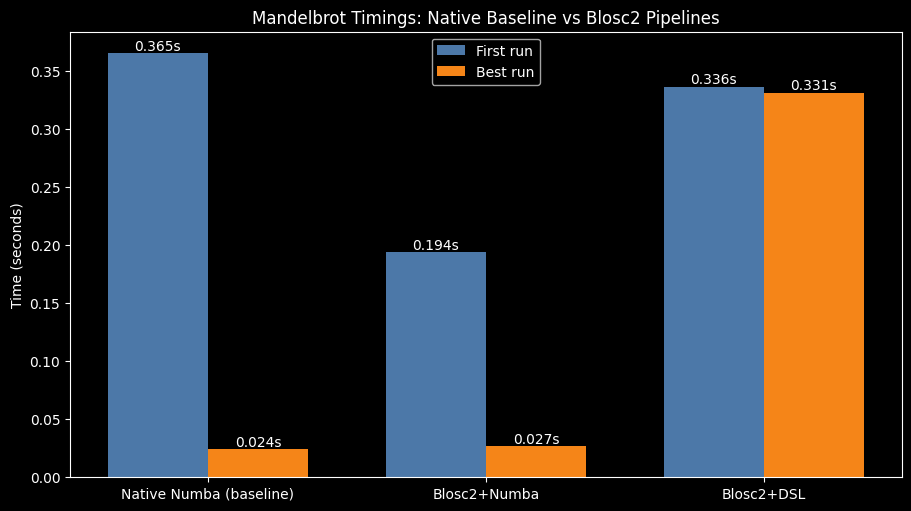

In [7]:
labels = ["Native Numba (baseline)", "Blosc2+Numba", "Blosc2+DSL"]
first_times = [t_numba_native_first, t_b2_numba_first, t_dsl_first]
best_times = [t_numba_native, t_b2_numba, t_dsl]

x = np.arange(len(labels))
width = 0.36

fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True)
ax.bar(x - width / 2, first_times, width, label="First run", color="#4C78A8")
ax.bar(x + width / 2, best_times, width, label="Best run", color="#F58518")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Time (seconds)")
ax.set_title("Mandelbrot Timings: Native Baseline vs Blosc2 Pipelines")
ax.legend()

for i, t in enumerate(first_times):
    ax.text(i - width / 2, t, f"{t:.3f}s", ha="center", va="bottom")
for i, t in enumerate(best_times):
    ax.text(i + width / 2, t, f"{t:.3f}s", ha="center", va="bottom")

plt.show()